# The purpose of this notebook is to get data from multiple data sources and transform them to common structure.

In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# VARIABLES
pd.options.mode.chained_assignment = None

In [3]:
def check_for_null_empty(df):
    nan_titles = df.isnull().values.any() 
    print(f"\nNaN titles dropped: { nan_titles }")
    df = df.dropna(subset=['title'])
    

    df["counts"] = df["title"].apply(lambda title: sum(1 for char in title if char.isalpha()))
    print(f"\nEmpty titles dropped: {sum(df["counts"] == 0)}")
    df = df.loc[df["counts"]!=0]
    return df

In [4]:
def plot_alphabetical(df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    df.boxplot(column=["counts"], ax=axs[0])
    axs[0].set_title('Boxplot of alphabetical characters in titles')

    sns.histplot(df["counts"], bins=10, kde=True, ax=axs[1], edgecolor="black")
    axs[1].set_xlabel('Counts')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of alphabetical characters in titles')

    plt.tight_layout()
    plt.show()

In [5]:
def outliers_iqr(df):
    Q1 = df["counts"].quantile(0.25)
    Q3 = df["counts"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df["counts"]<lower_bound) | (df["counts"]>upper_bound)]
    outliers["tail"] = df["counts"].apply(lambda count: "L" if count < lower_bound else "U")
    outliers = outliers.groupby(["tail", "clickbait"])["clickbait"].count().reset_index(name='count')
    return outliers

In [6]:
def plot_outliers(outliers):
    lower_outliers = outliers[outliers['tail'] == 'L']
    upper_outliers = outliers[outliers['tail'] == 'U']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(x='clickbait', y='count', data=lower_outliers, ax=axs[0], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[0].set_title('Less alphabetical than lower bound IQR')
    axs[0].set_xlabel('Clickbait')
    axs[0].set_ylabel('Count')
    axs[0].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    sns.barplot(x='clickbait', y='count', data=upper_outliers, ax=axs[1], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[1].set_title('More alphabetical than upper bound IQR')
    axs[1].set_xlabel('Clickbait')
    axs[1].set_ylabel('Count')
    axs[1].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    plt.tight_layout()
    plt.show()

In [7]:
def clickbait_dist_plot(df):
        print(f"\nShape: {df.shape}")
        num_clickbaits = df[df["clickbait"] == 1].shape[0]
        num_no_clickbaits = df[df["clickbait"] == 0].shape[0]

        print(f"Number of clickbaits: {num_clickbaits}")
        print(f"Number of no-clickbaits: {num_no_clickbaits}")

        labels = ['Clickbait', 'No-clickbait']
        sizes = [num_clickbaits, num_no_clickbaits]
        colors = ['red', 'green']
        explode = (0, 0)

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=False, startangle=90)
        plt.axis('equal')
        plt.title('Distribution of Clickbaits and No Clickbaits')
        plt.show()

In [8]:
def analyze_df(df):
    columns = df.columns.tolist()
    print(f"Columns: {columns}")
    clickbait_dist_plot(df)
    df = check_for_null_empty(df)
    plot_alphabetical(df)
    outliers = outliers_iqr(df)
    plot_outliers(outliers)
    return df[columns]

 ## #1 Data source: kaggle
 https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

In [9]:
df_1 = pd.read_csv("../data/clickbait_data.csv")
df_1.rename(columns={'headline': 'title'}, inplace=True)

Columns: ['title', 'clickbait']

Shape: (32000, 2)
Number of clickbaits: 15999
Number of no-clickbaits: 16001


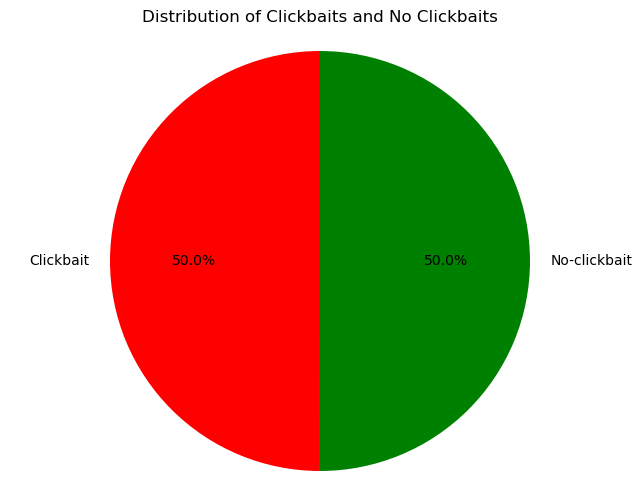


NaN titles dropped: False

Empty titles dropped: 0


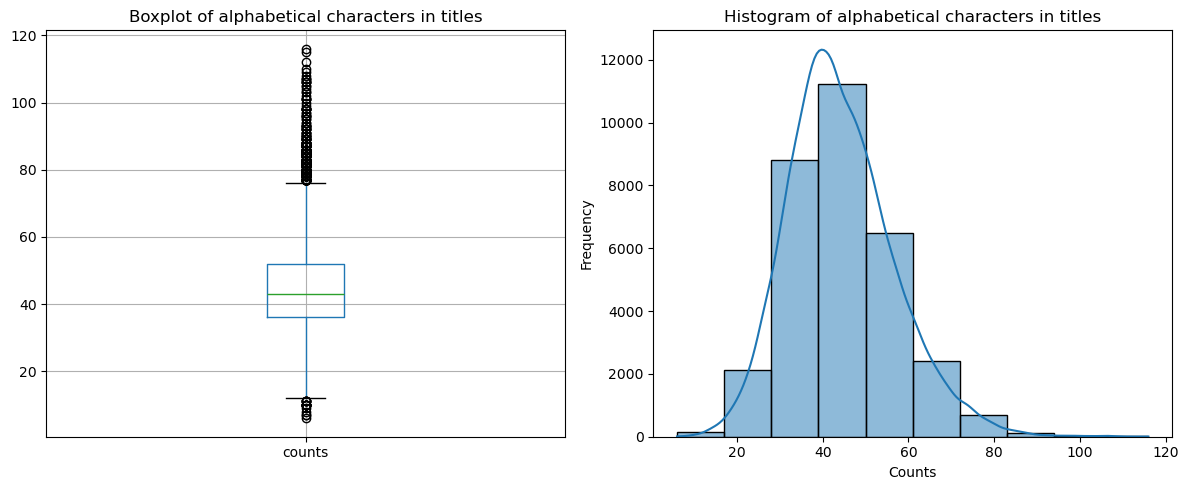

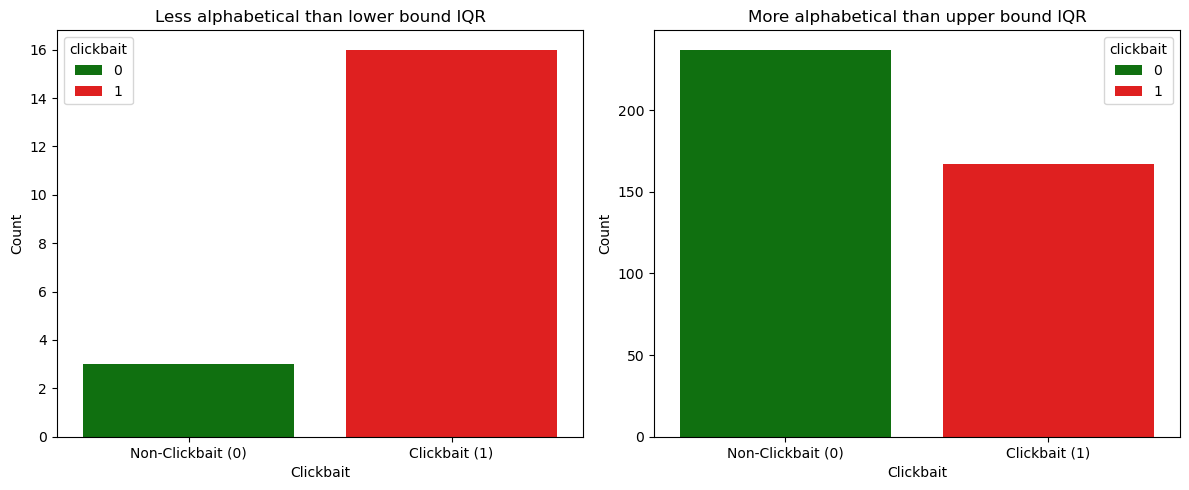

,title,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [10]:
df_1.head()
analyze_df(df_1)

 ## #2 Data source: kaggle 
https://www.kaggle.com/datasets/vikassingh1996/news-clickbait-dataset?select=train2.csv

In [11]:
df_news_2 = pd.read_csv("../data/train2.csv")
df_news_2['label'] = df_news_2['label'].apply(lambda x: 1 if x == 'clickbait' else 0)

df_news_2.rename(columns={'label': 'clickbait'}, inplace=True)
df_2 = df_news_2[['title', 'clickbait']]

Columns: ['title', 'clickbait']

Shape: (21029, 2)
Number of clickbaits: 4291
Number of no-clickbaits: 16738


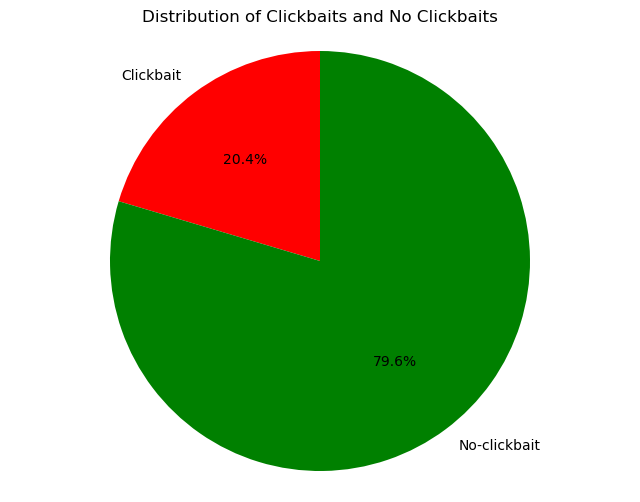


NaN titles dropped: False

Empty titles dropped: 0


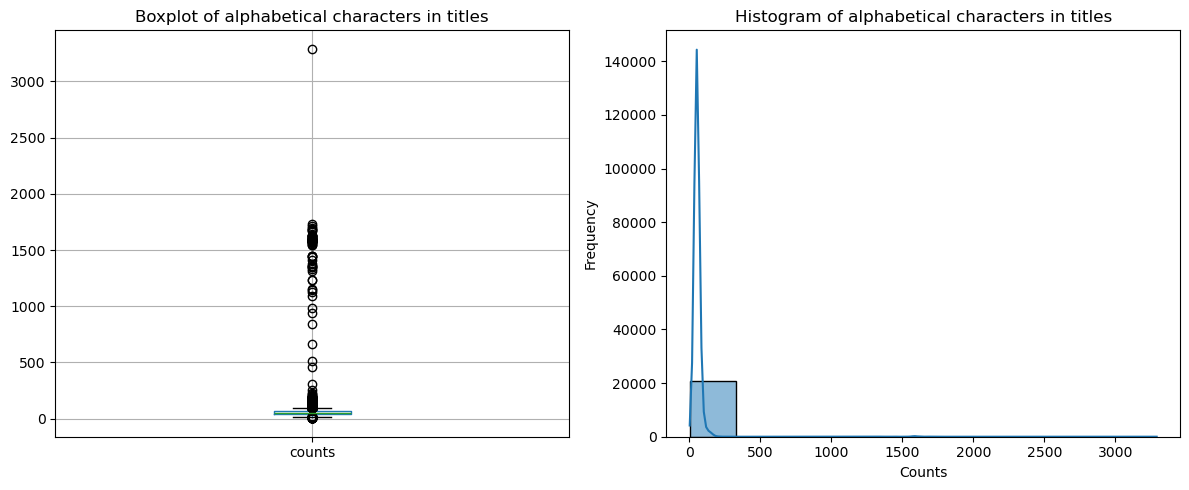

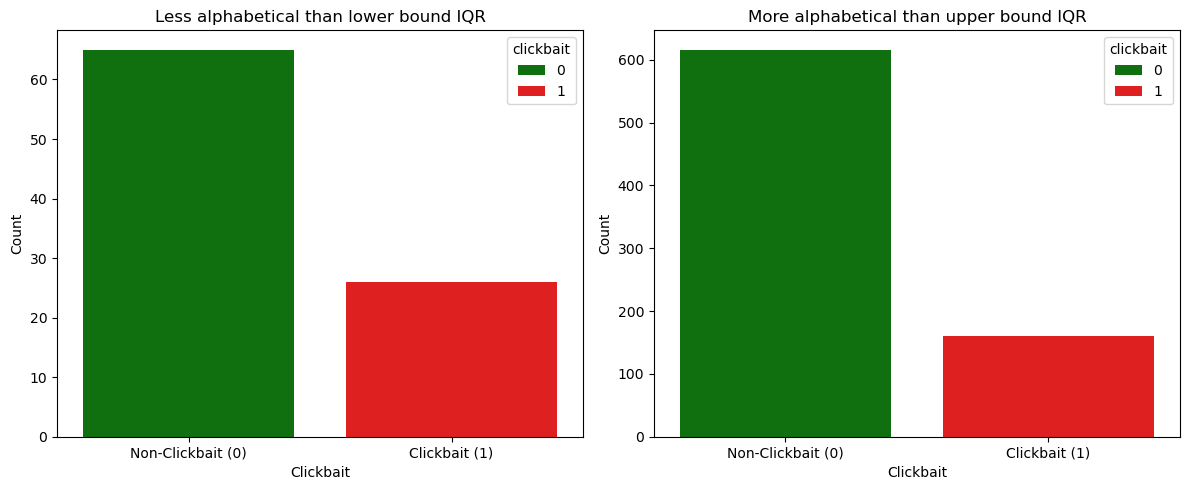

,title,clickbait
0,China and Economic Reform: Xi Jinping’s Track ...,0
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,0
2,"The Top Beaches In The World, According To Nat...",1
3,Sheriff’s Report Provides New Details on Tamir...,1
4,Surgeon claiming he will transplant volunteer'...,0
...,...,...
21024,The New Playboy and the End of Adulthood,0
21025,Use of weaponized drones by ISIS spurs terrori...,0
21026,Experts: China might be building database of f...,0
21027,How Trump Can Fix His Troubled White House,0


In [12]:
df_2.head()
analyze_df(df_2)

 ## #3 Data source: clickbait challenge 
https://webis.de/events/clickbait-challenge/shared-task.html

In [13]:
file_path = '../data/clickbait17-train-170331/instances.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    data_df = pd.read_json(file,lines=True)

file_path = '../data/clickbait17-train-170331/truth.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    labels = pd.read_json(file,lines=True)
    
labels = labels[["id", "truthClass"]]
data_df = data_df[["id", "targetTitle"]]

df_3 = pd.merge(data_df, labels, left_on='id', right_on='id', how='left')
df_3['truthClass'] = df_3['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
df_3.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
df_3 = df_3[["title", "clickbait"]]

# b)

file_path = '../data/clickbait17-validation-170630/instances.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    data_df = pd.read_json(file,lines=True)

file_path = '../data/clickbait17-validation-170630/truth.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    labels = pd.read_json(file,lines=True)
    
labels = labels[["id", "truthClass"]]
data_df = data_df[["id", "targetTitle"]]

df_4 = pd.merge(data_df, labels, left_on='id', right_on='id', how='left')
df_4['truthClass'] = df_4['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
df_4.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
df_4 = df_4[["title", "clickbait"]]

Columns: ['title', 'clickbait']

Shape: (2459, 2)
Number of clickbaits: 762
Number of no-clickbaits: 1697


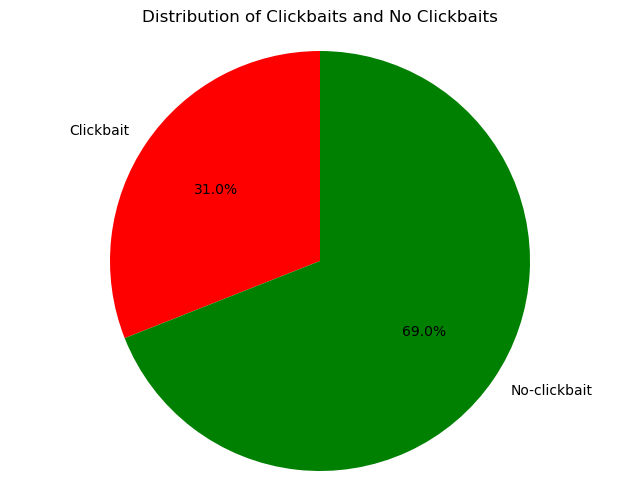


NaN titles dropped: False

Empty titles dropped: 0


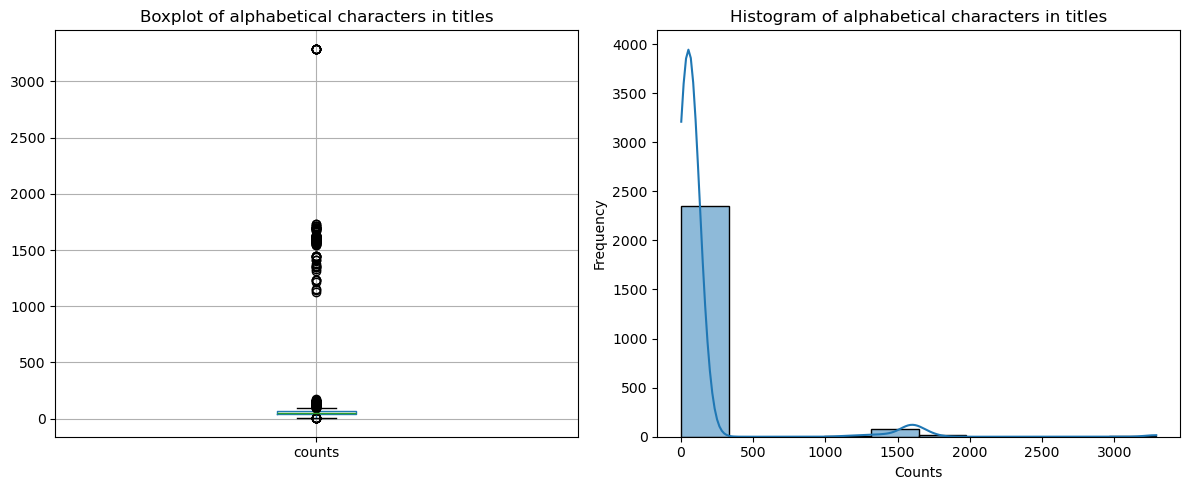

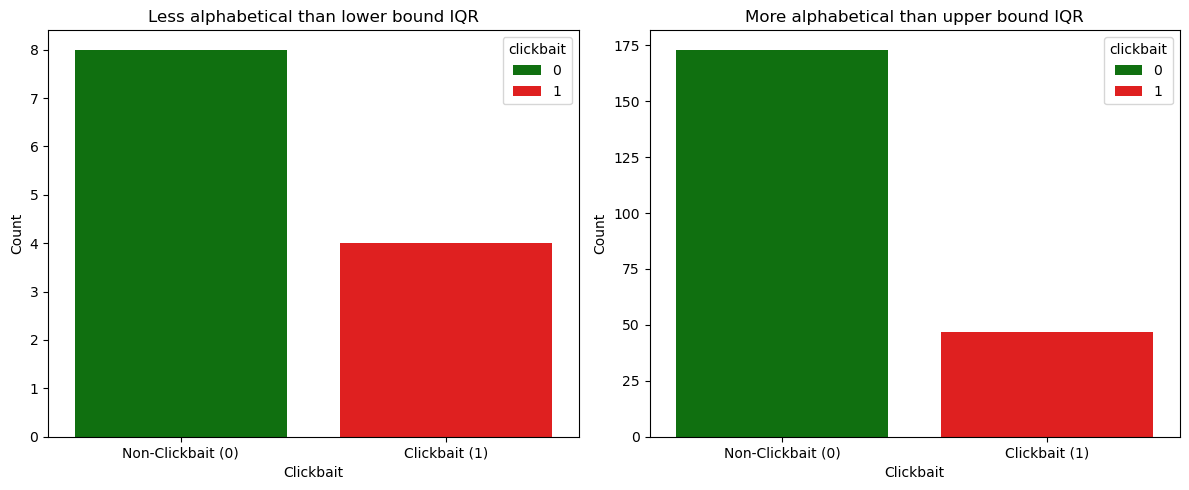

,title,clickbait
0,Apple gives back gigabytes: iOS 9 'app thinnin...,0
1,Emerging Markets Suffer Largest Outflow in Sev...,0
2,U.S. Soccer should start answering tough quest...,1
3,How theme parks like Disney World left the mid...,0
4,Warning labels on your light bulbs,1
...,...,...
2454,World's first penis transplant patient is set ...,1
2455,"At Women’s World Cup, Tie Leaves U.S. on Solid...",0
2456,Obama Defends Health Law Ahead of Supreme Cour...,0
2457,Deflating ‘Deflategate’,0


In [14]:
df_3.head()
analyze_df(df_3)

Columns: ['title', 'clickbait']

Shape: (19538, 2)
Number of clickbaits: 4761
Number of no-clickbaits: 14777


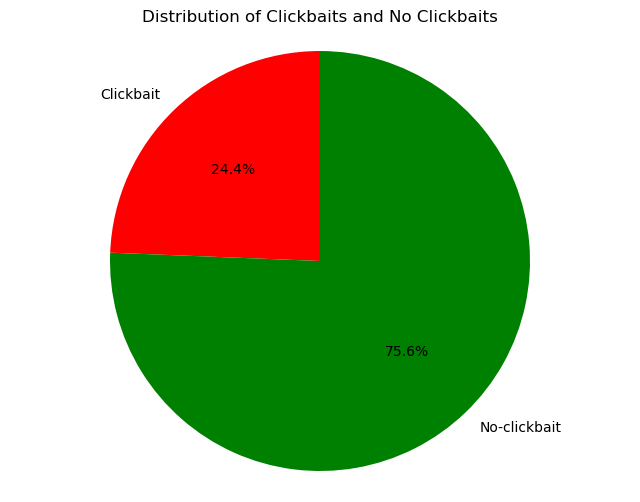


NaN titles dropped: False

Empty titles dropped: 0


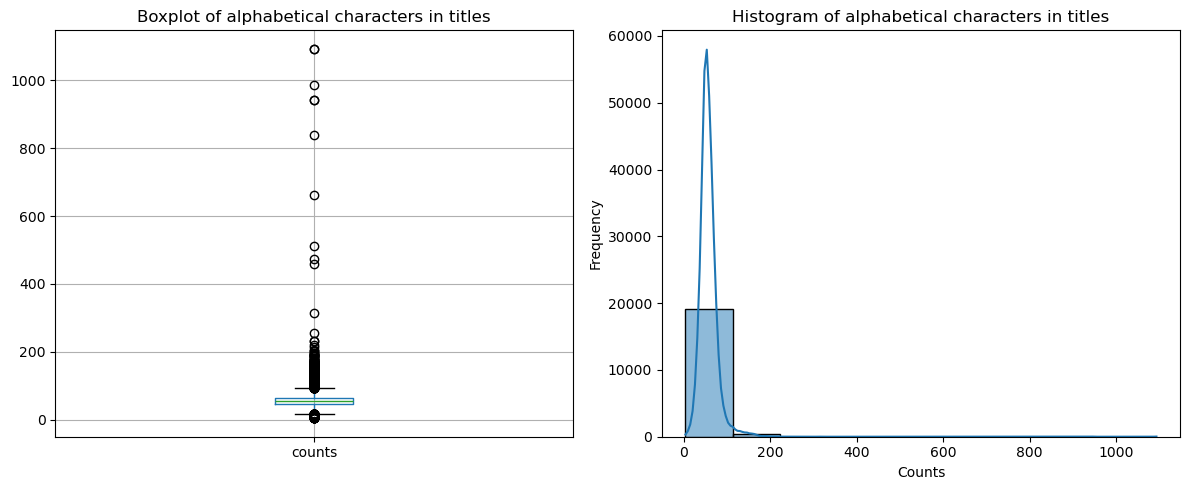

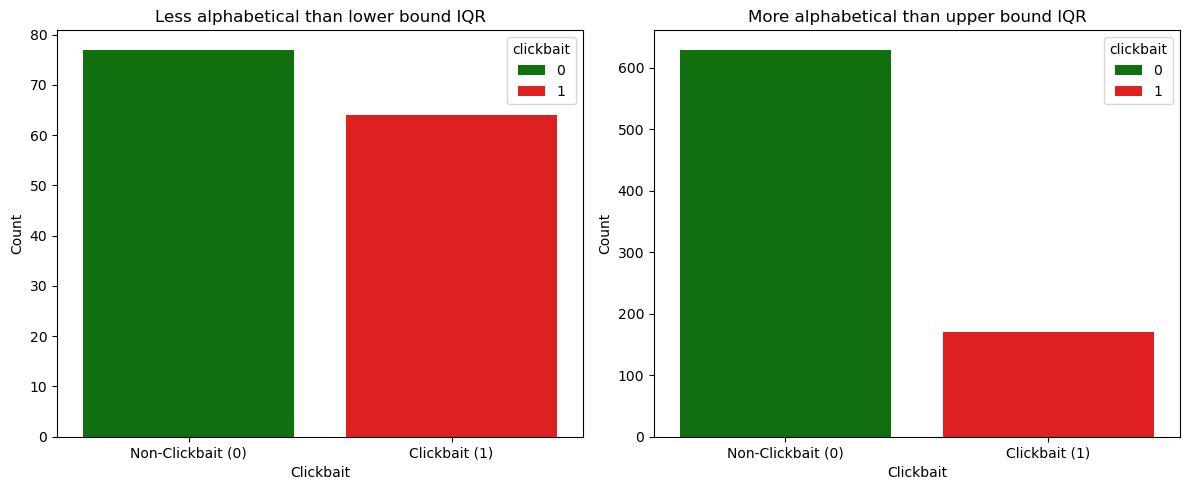

,title,clickbait
0,‘Inexcusable’ failures in UK’s response to mod...,0
1,Donald Trump Appoints Pro-Life Advocate as Ass...,1
2,The ‘forgotten’ Trump roast: Relive his brutal...,0
3,"Meet The Happiest Dog In The World, Maru The H...",1
4,Tokyo's subway is shut down amid fears over an...,0
...,...,...
19533,"NBC News Video See Brazil Soccer Team, Pilot’s...",0
19534,Politico Scoop: Eric Trump Killed Two Deer,1
19535,Frenchs Forest high school may relocate to mak...,0
19536,Los Angeles Rams Jeff Fisher May Think Danny W...,0


In [15]:
df_4.head()
analyze_df(df_4)

## Concatenate datasets

In [16]:
dfs = [
    df_1,
    df_2,
    df_3,
    df_4,
]

In [17]:
for df_ in dfs:
    print(df_.shape)

(32000, 2)
(21029, 2)
(2459, 2)
(19538, 2)


In [18]:
for i,df_ in enumerate(dfs):
    print("=========  " + str(i+1) +"- dataset =============")
    print(df_["clickbait"].value_counts())

=========  1- dataset =============
clickbait
0    16001
1    15999
Name: count, dtype: int64
=========  2- dataset =============
clickbait
0    16738
1     4291
Name: count, dtype: int64
=========  3- dataset =============
clickbait
0    1697
1     762
Name: count, dtype: int64
=========  4- dataset =============
clickbait
0    14777
1     4761
Name: count, dtype: int64


In [19]:
df_merged = pd.concat([df_1,df_2,df_3,df_4])

In [20]:
df_merged.to_csv("../data/merged_all_datasets.csv", index=False)

In [21]:
df_0_huge = df_merged[df_merged['clickbait'] == 0].sample(n=20000, random_state=42)
df_1_huge = df_merged[df_merged['clickbait'] == 1].sample(n=20000, random_state=42)
df_balanced_huge = pd.concat([df_0_huge, df_1_huge])

df_balanced_huge.to_csv("../data/merged_datasetes_balanced_huge.csv", index=False)

In [22]:
df_0 = df_merged[df_merged['clickbait'] == 0].sample(n=10000, random_state=42)
df_1 = df_merged[df_merged['clickbait'] == 1].sample(n=10000, random_state=42)

df_balanced = pd.concat([df_0, df_1])

In [23]:
df_balanced.to_csv("../data/merged_datasetes_balanced.csv", index=False)

## + Dataset with body: clickbait challange
https://webis.de/events/clickbait-challenge/shared-task.html

In [24]:
def load_data_cc(name, columns=[]):
    """
    loads data from clickbait challenge webis corpus
    
    name (str): name of the folder
    columns (list): list of columns names to extract apart from 'id' and 'targetTitle'
    """
    data_file_path = f'../data/{name}/instances.jsonl'
    with open(data_file_path, 'rb') as file:
        data_df = pd.read_json(file,lines=True)

    target_file_path = f'../data/{name}/truth.jsonl'
    with open(target_file_path, 'rb') as file:
        labels = pd.read_json(file,lines=True)
    
    data_df = data_df[["id", "targetTitle"] + columns]
    labels = labels[["id", "truthClass"]]

    df = pd.merge(data_df, labels, on='id', how='left')
    df.drop(['id'], axis=1, inplace=True)
    df['truthClass'] = df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
    df.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
    return df

In [25]:
files = ["clickbait17-train-170331", "clickbait17-test-170720", "clickbait17-validation-170630"]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename, columns=["targetParagraphs"])
    part_df['body'] = part_df['targetParagraphs'].apply(lambda x: " ".join(x))
    part_df = part_df[['title', 'body', 'clickbait']]
    body_dfs.append(part_df)
df_body = pd.concat(body_dfs).reset_index(drop=True)

In [26]:
df_body['clickbait'].value_counts()

clickbait
0    30938
1    10038
Name: count, dtype: int64

In [27]:
df_body.to_csv("../data/cc_dataset.csv", index=False)

In [28]:
df_00 = df_body[df_body['clickbait'] == 0].sample(n=10000, random_state=37)
df_01 = df_body[df_body['clickbait'] == 1].sample(n=10000, random_state=37)

df_body_balanced = pd.concat([df_00, df_01])

In [29]:
df_body_balanced.to_csv("../data/cc_dataset_balanced.csv", index=False)

## Clickbait spoiling dataset

https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html

In [30]:
"""
Vocab:
task 1: spoiler type classification
task 2: spoiler generation / extraction

Columns:
targetTitle: The title of the linked web page.
targetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.
humanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.
spoiler: The human extracted spoiler for the clickbait post from the linked web page.
spoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.
tags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).

How to use spoilerPositions:
if `data['spoilerPositions'][0]` is `[[[3, 151], [3, 186]]]`,
then `data['targetParagraphs'][0][3][151:186]` equals `data['spoiler']`
"""

'\nVocab:\ntask 1: spoiler type classification\ntask 2: spoiler generation / extraction\n\nColumns:\ntargetTitle: The title of the linked web page.\ntargetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.\nhumanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.\nspoiler: The human extracted spoiler for the clickbait post from the linked web page.\nspoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.\ntags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).\n\nHow to use spoilerPositions:\nif `data[\'spoilerPositions\'][0]` is `[[[3, 151], [3, 186]]]`,\nthen `data[\'targetParagraphs\'][0][3][151:186]` equals `data[\'spoiler\']`\n'

In [31]:
names = ['train', 'validation']
spoil_dfs = []
for name in names:
    data_file_path = f'../../data/spoiling-clickbait-22/{name}.jsonl'
    with open(data_file_path, 'rb') as file:
        part_df = pd.read_json(file,lines=True)

    part_df['humanSpoiler'] = part_df['provenance'].apply(lambda x: x['humanSpoiler'])
    part_df = part_df[["targetTitle", "targetParagraphs", "humanSpoiler", "spoiler", "spoilerPositions", "tags"]]
    spoil_dfs.append(part_df)
spoil_df = pd.concat(spoil_dfs).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/spoiling-clickbait-22/train.jsonl'

In [37]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)